### DCGAN - MNIST dataset

Based on the previous notebook we are going to use the `Conv2DTranspose()` during generator model creation instead of the `UpSampling2D()` and see if we are going to get the same results. The rest of the code will remain the same we are only going to touch the Generator model by changing the `UpSampling2D` layer to the `Conv2DTranspose()`  layer.

The `Conv2DTranspose()` is a combination of `conv2D` and `UpSampling2D()` in particular. From one of my notebooks I've explained the relationship between these layers.

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
import sys, os

print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.5.0


### Generator Model.

For the last layer we wil be using a `tanh` activation function and for the hidden layers we will be using the `relu` activation function.

In [2]:
class GenBlock(keras.layers.Layer):
  def __init__(self, in_features, kernel_size=3, strides=(2, 2), padding="same", momentum=.8):
    super(GenBlock, self).__init__()
    self.conv_2d_transpose = keras.layers.Conv2DTranspose(in_features, kernel_size=kernel_size, padding=padding, strides=strides)
    self.bn = keras.layers.BatchNormalization(momentum=momentum)
    self.relu = keras.layers.ReLU()

  def call(self, x):
    x = self.conv_2d_transpose(x)
    x = self.bn(x)
    return self.relu(x)
class GenOutputBlock(keras.layers.Layer):
  def __init__(self, channels=1,  kernel_size=3):
    super(GenOutputBlock, self).__init__(self)
    self.conv = keras.layers.Conv2D(channels, kernel_size=kernel_size, padding='same')
    self.tanh = keras.activations.tanh
  def call(self, x):
    x = self.conv(x)
    return self.tanh(x)

latent_dim = 128
input_dim = 100
channels = 1
gen_model = keras.Sequential([
        keras.layers.Dense(latent_dim * 7 * 7, activation='relu', input_dim=input_dim),
        keras.layers.Reshape((7, 7, latent_dim)),
        GenBlock(128),
        GenBlock(in_features=64),
        GenOutputBlock(channels=channels)
], name="generator_model")

gen_model.build(input_shape=(input_dim, ))
gen_model.summary()

Model: "generator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
gen_block (GenBlock)         (None, 14, 14, 128)       148096    
_________________________________________________________________
gen_block_1 (GenBlock)       (None, 28, 28, 64)        74048     
_________________________________________________________________
gen_output_block (GenOutputB (None, 28, 28, 1)         577       
Total params: 856,193
Trainable params: 855,809
Non-trainable params: 384
_________________________________________________________________


### Discriminator Model.
In this model we are going to use the `LeakyReLU` activation function for hidden layers and `sigmoid` for  the output layer.

In [3]:
class DBlock(keras.layers.Layer):
  def __init__(self, in_features, kernel_size=3, padding="same", zero_padding=False, momentum=.8,
               alpha=.2, dropout=.25):
    super(DBlock, self).__init__()

    self.zero_padding = zero_padding
    self.conv = keras.layers.Conv2D(in_features, kernel_size=kernel_size,
                                    padding=padding)
    self.zero_padding_layer = keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))
    self.bn = keras.layers.BatchNormalization(momentum=momentum)
    self.leaky_relu = keras.layers.LeakyReLU(alpha=alpha)
    self.dropout = keras.layers.Dropout(rate=dropout)
  
  def call(self, x):
    x = self.dropout(x)
    x = self.conv(x)
    if self.zero_padding:
      x = self.zero_padding_layer(x)
    x = self.bn(x)
    x = self.leaky_relu(x)
    return x

class DOutputBlock(keras.layers.Layer):
  def __init__(self, channels=1, activation='sigmoid', dropout=.25 ):
    super(DOutputBlock, self).__init__()
    self.flatten = keras.layers.Flatten()
    self.fc = keras.layers.Dense(channels, activation=activation)
    self.dropout = keras.layers.Dropout(rate=dropout)

  def call(self, x):
    x = self.dropout(x)
    x = self.flatten(x)
    return self.fc(x)


image_shape = (28, 28, 1)

disc_model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same") ,
    keras.layers.LeakyReLU(alpha=0.2), 
     DBlock(64, zero_padding=True),
     DBlock(128),
     DBlock(256),
     DOutputBlock(1)         
], name="discriminator_model")

disc_model.summary()

Model: "discriminator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
d_block (DBlock)             (None, 15, 15, 64)        18752     
_________________________________________________________________
d_block_1 (DBlock)           (None, 15, 15, 128)       74368     
_________________________________________________________________
d_block_2 (DBlock)           (None, 15, 15, 256)       296192    
_________________________________________________________________
d_output_block (DOutputBlock (None, 1)                 57601     
Total params: 447,233
Trainable params: 446,337
Non-trainable params: 896
_______________________________________

### Generating a single image before training.

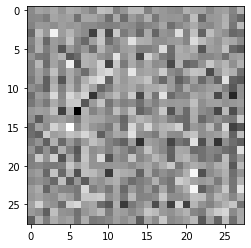

In [4]:
noise = tf.random.normal([1, 100])
generated_image = gen_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

### Using the discriminator to identify the generated image before training.

In [5]:
disc_model(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50032645]], dtype=float32)>

### Loss Functions.

If you want explanation on how things are going visit [this](https://github.com/CrispenGari/Keras-API/blob/main/13_Unsupervised_L/01_DC_GANS_01/06_GANS_FaceGeneration_Introduction.ipynb) notebook.

In [6]:
cross_entropy = keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return fake_loss

### Optimizers

In [7]:
generator_optimizer = keras.optimizers.Adam(1.5e-4, .5)
discriminator_optimizer = keras.optimizers.Adam(1.5e-4, .5)

### Train step function

In [8]:
BATCH_SIZE = 32
SEED_SIZE = 100
BUFFER_SIZE = 60000

In [9]:
@tf.function
def train_step(images):
  seed = tf.random.normal((BATCH_SIZE, SEED_SIZE))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = gen_model(seed, training=True)

    real_output = disc_model(images, training= True)
    fake_output = disc_model(generated_images, training=True)

    gen_loss = generator_loss(fake_output=fake_output)
    disc_loss = discriminator_loss(real_output=real_output, fake_output=fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    # UPDATING THE WEIGHTS
    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, gen_model.trainable_variables
    ))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, disc_model.trainable_variables
    ))
    return gen_loss, disc_loss

### Train Function

Saving images.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
from PIL import Image
base_path = '/content/drive/MyDrive'
saving_directory = os.path.join(base_path, 'mnist_generated')
if os.path.exists(saving_directory):
  pass
else:
  print("Creating a new directory...")
  os.mkdir(saving_directory)
def save_images(epoch, fixed_seed,  total_per_epoch=3):
  generated_images = gen_model(fixed_seed[:total_per_epoch])
  generated_images = 0.5 * generated_images + 0.5
  generated_images = generated_images * 255
  for index, image_array in enumerate(generated_images):
      filename = os.path.join(saving_directory,f"train_{epoch}_{index}.png")
      im = Image.fromarray(np.array(image_array, dtype=np.uint8))
      im.save(filename)
  print("Total images saved: ", total_per_epoch)

A function that tracks how long training is taking per epoch.

In [13]:
import time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [14]:
def train(dataset, epochs):
  fixed_seed = tf.random.normal([10, SEED_SIZE])
  start = time.time()
  for epoch in range(epochs):
    epoch_start = time.time()
    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_list.append(gen_loss)
      disc_loss_list.append(disc_loss)
    g_loss = sum(gen_loss_list)/len(gen_loss_list)
    d_loss = sum(disc_loss_list)/len(disc_loss_list)

    epoch_end = time.time()
    print (f'Epoch {epoch+1} [ gen loss: {g_loss} ] [ disc loss: {d_loss} ] ETA: {hms_string(epoch_end - epoch_start)}')
    # save_images(epoch=epoch, fixed_seed=fixed_seed, total_per_epoch=5)
  end = time.time()
  print (f'Training time: {hms_string(end - start)}')

### Creating the dataset from the mnist digits datset

In [ ]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

### Plotting Real mnist Digits.

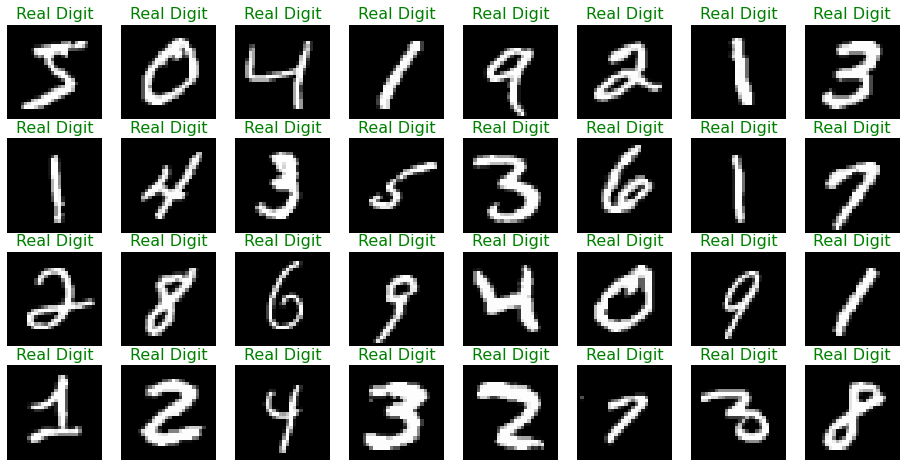

In [16]:
def plot_images(images_and_classes, cols=5):
    rows = 4
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap="gray")
        plt.title("Real Digit", color ='g', fontsize=16 )

plot_images(X_train[:32], cols=8)

In [17]:
def reshape_normalize(image):
  image = tf.cast(tf.reshape(image, shape=(28, 28, 1)), dtype=tf.float32)
  image = image / 255.0
  return image

In [18]:
ds = tf.data.Dataset.from_tensor_slices(X_train).map(reshape_normalize).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

### Training.

Now that we have our data let's train the model.

In [19]:
train(ds, 50)

Epoch 1 [ gen loss: 8.998454093933105 ] [ disc loss: 0.09324462711811066 ] ETA: 0:00:33.24
Epoch 2 [ gen loss: 8.925646781921387 ] [ disc loss: 0.12566572427749634 ] ETA: 0:00:31.80
Epoch 3 [ gen loss: 7.657073020935059 ] [ disc loss: 0.17455743253231049 ] ETA: 0:00:31.36
Epoch 4 [ gen loss: 6.696396827697754 ] [ disc loss: 0.22165143489837646 ] ETA: 0:00:31.38
Epoch 5 [ gen loss: 5.980472564697266 ] [ disc loss: 0.28454655408859253 ] ETA: 0:00:31.47
Epoch 6 [ gen loss: 5.782625198364258 ] [ disc loss: 0.2860807180404663 ] ETA: 0:00:31.33
Epoch 7 [ gen loss: 5.764192581176758 ] [ disc loss: 0.2782078683376312 ] ETA: 0:00:31.35
Epoch 8 [ gen loss: 5.503174781799316 ] [ disc loss: 0.3310913145542145 ] ETA: 0:00:31.38
Epoch 9 [ gen loss: 5.452436447143555 ] [ disc loss: 0.32842737436294556 ] ETA: 0:00:31.31
Epoch 10 [ gen loss: 5.306086540222168 ] [ disc loss: 0.3481382429599762 ] ETA: 0:00:31.23
Epoch 11 [ gen loss: 5.107616901397705 ] [ disc loss: 0.3797338902950287 ] ETA: 0:00:31.35
Ep

### Retrain the model for more epochs.

Since the model loss is still decreasing we can keep on training it for some more `epochs`.

In [24]:
train(ds, 50)

Epoch 1 [ gen loss: 3.655320167541504 ] [ disc loss: 0.5895501375198364 ] ETA: 0:00:31.64
Epoch 2 [ gen loss: 3.583796262741089 ] [ disc loss: 0.605065107345581 ] ETA: 0:00:31.59
Epoch 3 [ gen loss: 3.6341397762298584 ] [ disc loss: 0.6142675876617432 ] ETA: 0:00:31.23
Epoch 4 [ gen loss: 3.6495890617370605 ] [ disc loss: 0.5758626461029053 ] ETA: 0:00:31.43
Epoch 5 [ gen loss: 3.615570545196533 ] [ disc loss: 0.579021692276001 ] ETA: 0:00:31.38
Epoch 6 [ gen loss: 3.60137939453125 ] [ disc loss: 0.5979738831520081 ] ETA: 0:00:31.40
Epoch 7 [ gen loss: 3.62668776512146 ] [ disc loss: 0.5995293855667114 ] ETA: 0:00:31.40
Epoch 8 [ gen loss: 3.5781898498535156 ] [ disc loss: 0.5953206419944763 ] ETA: 0:00:31.37
Epoch 9 [ gen loss: 3.593981981277466 ] [ disc loss: 0.5772570371627808 ] ETA: 0:00:31.29
Epoch 10 [ gen loss: 3.5600357055664062 ] [ disc loss: 0.6112375259399414 ] ETA: 0:00:31.32
Epoch 11 [ gen loss: 3.6106882095336914 ] [ disc loss: 0.5902129411697388 ] ETA: 0:00:31.43
Epoch 1

### Generating images.

In [27]:
seeds = tf.random.normal([32, SEED_SIZE])
generated = gen_model(seeds, training=False)

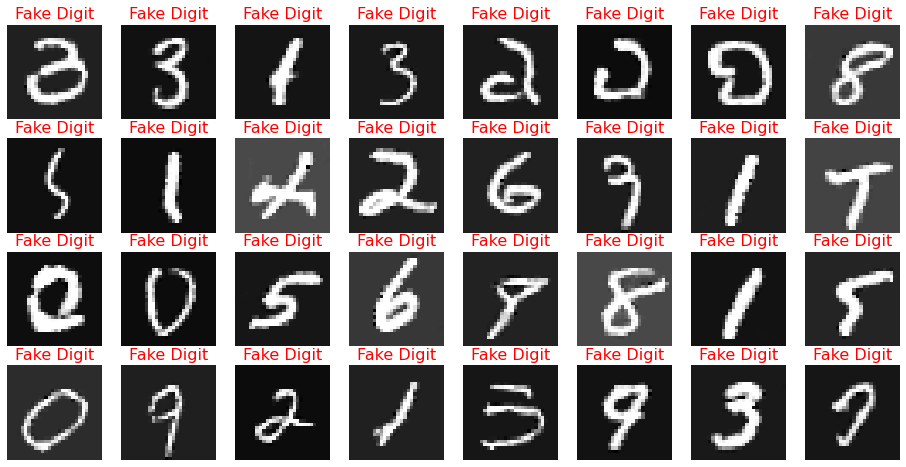

In [28]:
def plot_images(images_and_classes, cols=5):
    rows = 4
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(np.array(image.numpy() * 255,np.int32)[:, :, 0] , cmap="gray")
        plt.title("Fake Digit", color ='r', fontsize=16 )

plot_images(generated[:], cols=8)